In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from itertools import combinations

import sklearn
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import xgboost as xgb

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\preliminary_models'

### Binning profile data and merging to satellite data

In [2]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

# cut out outlying depth values
profile_df = profile_df[profile_df.PRES < 1001]
# bin the data using 50 bins and group it
out = pd.cut(profile_df.PRES, bins=100, labels=[i for i in range(100)])
profile_df['depth_bin'] = out

depth_profiles = profile_df[['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()
df_depth['date'] = pd.to_datetime(df_depth.date, format='%Y-%m-%d %H:%M:%S')

### Preprocessing

In [3]:
bins_to_use = [i for i in range(100)]
df = df_depth[df_depth.depth_bin.isin(bins_to_use)]
df["depth_bin"] = df.loc[:, 'depth_bin'].astype("int64").astype("category")
# turn date into radians
df['date_doy'] = df.loc[:, 'date'].apply(lambda x: x.day_of_year)
df['date_doy_rad'] = df.loc[:, 'date_doy'] * (np.pi /182.625)

### Feature merging for selection

In [6]:
df_pic = pd.read_csv('../data/sat_pic_full_final.csv').drop(['sat_pic_day', 'sat_pic_8d', 'short_date'], axis=1)
df_par = pd.read_csv('../data/par_full_final.csv').drop(['par_day', 'par_8d', 'short_date'], axis=1)
df_aph = pd.read_csv('../data/aph_443_full_final.csv').drop(['aph_443_day', 'aph_443_8d', 'short_date'], axis=1)

new_features_df = df_pic.merge(df_par, on=['latitude', 'longitude'])
new_features_df = new_features_df.merge(df_aph, on=['latitude', 'longitude'])

In [7]:
df_round_coords = df.copy()
# round lat and lon to match new data
df_round_coords['latitude'] = df_round_coords.latitude.apply(lambda x: np.around(x, 3))
df_round_coords['longitude'] = df_round_coords.longitude.apply(lambda x: np.around(x, 3))

# merge the new features
model_df = df_round_coords[df_round_coords.depth_bin.isin([0, 3, 6, 9, 12, 15])].merge(new_features_df, on=['latitude', 'longitude']).dropna().drop_duplicates()

### Model Testing

In [8]:
def get_combinations(ls):
    combos = []
    for i in range(len(ls) + 1):
        combos += list(combinations(ls, i))
    return [list(x) for x in combos]

def model_scoring(model, X, y, argument_dict=None, cv=5):
    # for sklearn API compatible gradient boosting models
    
    if not argument_dict:
        # train vanilla model
        cv_results = cross_validate(model, X, y, cv=cv,
                                    scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                    return_estimator=False,
                                    return_train_score=True)
        return cv_results
    else:
        # do a grid search
        gs_results = GridSearchCV(model,
                                  param_grid = [argument_dict], cv=cv,
                                  scoring=['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'],
                                  refit='neg_root_mean_squared_error',
                                  return_train_score=True)
        gs_results.fit(X, y)
        return gs_results

### Train models using all combinations of feature possibilities

In [9]:
vital_feats = ["latitude", "longitude", "date_doy_rad", "depth_bin"]
added_feats = ["MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST", "sat_pic_month", "par_month", "aph_443_month"]
added_feat_combos = get_combinations(added_feats)
combo_scores = dict()

for c in added_feat_combos:
    Xc_boost = model_df[vital_feats + c]
    yc_boost = model_df["CHLA"]
    X_tr, X_te, y_tr, y_te = train_test_split(Xc_boost, yc_boost, test_size=0.05, random_state=23)

    xgbr = xgb.XGBRegressor(tree_method='gpu_hist')
    xgbr_scoring = model_scoring(xgbr, X_tr.to_numpy(), y_tr.to_numpy(), cv=5)
    combo_scores['__'.join(c)] = xgbr_scoring

### Model performance visualization

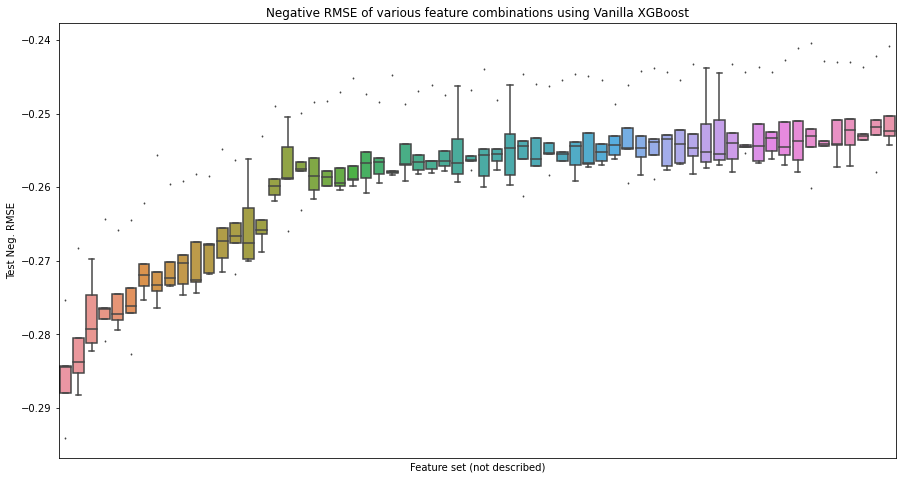

In [10]:
td = {k:v for (k, v) in zip(combo_scores.keys(), [combo_scores[x]['test_neg_root_mean_squared_error'] for x in combo_scores.keys()])}
td_df = pd.DataFrame(td)
mean_td = td_df.reindex(td_df.mean().sort_values().index, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.boxplot(data=mean_td, ax=ax, fliersize=1)
ax.set_ylabel('Test Neg. RMSE')
ax.set_xlabel('Feature set (not described)')
ax.set_title('Negative RMSE of various feature combinations using Vanilla XGBoost')
ax.tick_params(bottom=False, labelbottom=False)
plt.savefig('../visualizations/feature_set_nrmse_w_sat_chla.png')

In [11]:
mean_td.columns[-5:]

Index(['MO_SAT_CHL__MO_SAT_SST__sat_pic_month__aph_443_month',
       'MO_SAT_CHL__MO_SAT_SST__par_month',
       'MO_SAT_CHL__MO_SAT_BBP__MO_SAT_SST__par_month__aph_443_month',
       'MO_SAT_CHL__MO_SAT_SST__sat_pic_month',
       'MO_SAT_CHL__MO_SAT_BBP__MO_SAT_SST__par_month'],
      dtype='object')

### Create pivoted dataframe

In [30]:
piv_df = df_round_coords.merge(new_features_df, on=['latitude', 'longitude']).dropna().drop_duplicates()
pivoted_ls = list()
curr_float, curr_cycle = -1, -1
pivot_row = ''
for i, r in piv_df.iterrows():
    # new cycle
    if (curr_float != r.float) and (curr_cycle != r.cycleNumber):
        pivoted_ls.append(pivot_row)
        curr_float = r.float
        curr_cycle = r.cycleNumber
        pivot_row = {
            'float': curr_float,
            'cycleNumber': curr_cycle,
            'latitude': r.latitude,
            'longitude': r.longitude,
            'date_doy_rad': r.date_doy_rad,
            'sat_chl_month': r.MO_SAT_CHL,
            'sat_sst_month': r.MO_SAT_SST,
            'sat_par_month': r.par_month,
            'sat_pic_month': r.sat_pic_month,
            'sat_aph_443_month': r.aph_443_month
        }
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    # continuing from past cycle
    elif curr_cycle != r.cycleNumber:
        pivoted_ls.append(pivot_row)
        curr_cycle = r.cycleNumber
        pivot_row = {
            'float': curr_float,
            'cycleNumber': curr_cycle,
            'latitude': r.latitude,
            'longitude': r.longitude,
            'date_doy_rad': r.date_doy_rad,
            'sat_chl_month': r.MO_SAT_CHL,
            'sat_sst_month': r.MO_SAT_SST,
            'sat_par_month': r.par_month,
            'sat_pic_month': r.sat_pic_month,
            'sat_aph_443_month': r.aph_443_month
        }
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    else:
        pivot_row['depth_bin_' + str(r.depth_bin)] = r.CHLA
    

**Check missing values in new dataframe (in first 60 bins (0-600 ft of depth)) and impute missing values**

In [43]:
cluster_df = pd.DataFrame(pivoted_ls[1:])
cluster_df.iloc[:, 10:]

,depth_bin_0,depth_bin_1,depth_bin_2,depth_bin_3,depth_bin_4,depth_bin_5,depth_bin_6,depth_bin_7,depth_bin_8,depth_bin_9,...,depth_bin_90,depth_bin_91,depth_bin_92,depth_bin_93,depth_bin_94,depth_bin_95,depth_bin_96,depth_bin_97,depth_bin_99,depth_bin_98
0,0.704058,0.702668,0.678800,0.668311,0.734552,0.932129,1.098108,0.814539,0.684214,0.449756,...,0.005181,0.005181,0.005243,0.005618,0.005306,0.005930,0.005431,0.005930,0.006243,NaN
1,0.691814,0.665761,0.750091,0.769773,0.838611,1.308873,1.385440,0.939163,0.647262,0.436683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.063866,1.064480,0.979005,0.942488,0.954018,1.222963,1.086416,0.848111,0.533261,0.302491,...,0.005071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.432731,1.409791,1.424486,1.514563,1.416844,1.371946,0.883025,0.370423,0.146220,0.090078,...,0.004743,0.005556,0.005743,0.005618,0.006055,0.005993,0.005993,0.004868,0.004681,NaN
4,1.008395,1.038687,1.047004,1.039988,1.044929,1.022055,0.949463,0.244267,0.086929,0.062677,...,0.006305,0.005930,0.006118,0.005618,0.004837,0.004868,0.005431,0.005618,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44707,0.284700,0.284700,0.285048,0.285977,0.239667,0.183173,0.187004,0.164543,0.103475,0.075797,...,0.002083,0.000607,0.000854,0.002476,0.003602,0.003279,0.002099,0.000920,0.000036,0.000036
44708,0.186150,0.186150,0.186150,0.186414,0.179878,0.158747,0.141454,0.098848,0.074134,0.041898,...,-0.000050,-0.000033,-0.000034,-0.000058,-0.000274,-0.001046,-0.001246,-0.001227,-0.000046,-0.000818
44709,0.065700,0.065700,0.067438,0.126242,0.262275,0.232712,0.189794,0.210563,0.087057,0.074056,...,-0.000073,-0.000067,-0.000043,-0.000018,-0.000011,-0.000053,-0.000083,-0.000124,NaN,-0.000135
44710,0.025550,0.026158,0.048106,0.092426,0.140644,0.196006,0.269199,0.184985,0.108543,0.070227,...,0.000054,-0.000022,-0.000956,-0.001261,-0.001543,-0.002013,-0.001258,-0.001257,-0.001257,-0.001257


In [44]:
# if not already saved
'''
cluster_df.iloc[:, 10:] = IterativeImputer().fit_transform(cluster_df.iloc[:, 10:])
cluster_df.to_csv('../data/pivoted_imp_data.csv', index=False)
'''

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Data pipeline beginning
**Below is a step-by-step follow through of what our model might look like to find subsurface CHLA distributions**

In [2]:
# if saved
dists_to_cluster = pd.read_csv('../data/pivoted_imp_data.csv', index_col=False)
# split data
train_dtc, test_dtc = train_test_split(dists_to_cluster, test_size=0.15, random_state=23)
# Cluster the distributions based on FIRST 25 observations (0-260ft)
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(train_dtc.iloc[:, 10:35])
centers = kmeans.cluster_centers_
train_dtc['cluster'] = clusters

**Now we check out the kmeans centers representing our CHLA distributions**

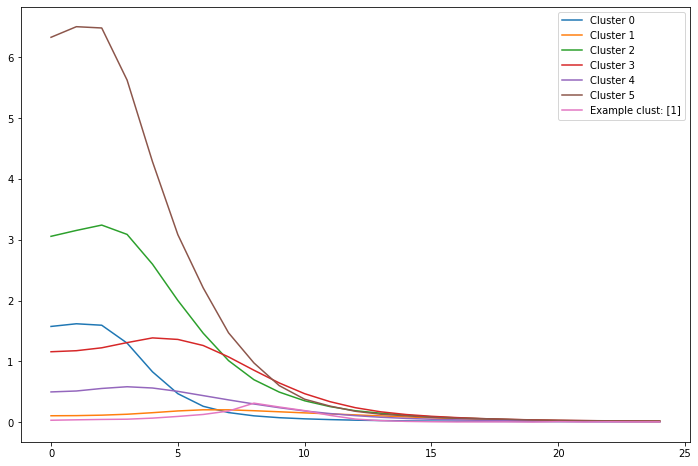

In [3]:
from cProfile import label

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
for i in range(centers.shape[0]):
    ax.plot(centers[i, :], label=f'Cluster {i}')
sample = train_dtc.sample()
ax.plot(sample.iloc[:, 10:35].to_numpy()[0], label=f'Example clust: {sample.cluster.to_numpy()}')
ax.legend()
plt.show()

**Fit the distributions to an unnormalized gaussian function with 4 parameters (can be improved later)**

C:\Users\johnc\AppData\Local\Temp\ipykernel_38952\3128482045.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - u)**2) + c
C:\Users\johnc\AppData\Local\Temp\ipykernel_38952\3128482045.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - u)**2) + c
C:\Users\johnc\AppData\Local\Temp\ipykernel_38952\3128482045.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - u)**2) + c
C:\Users\johnc\AppData\Local\Temp\ipykernel_38952\3128482045.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * (x - u)**2) + c


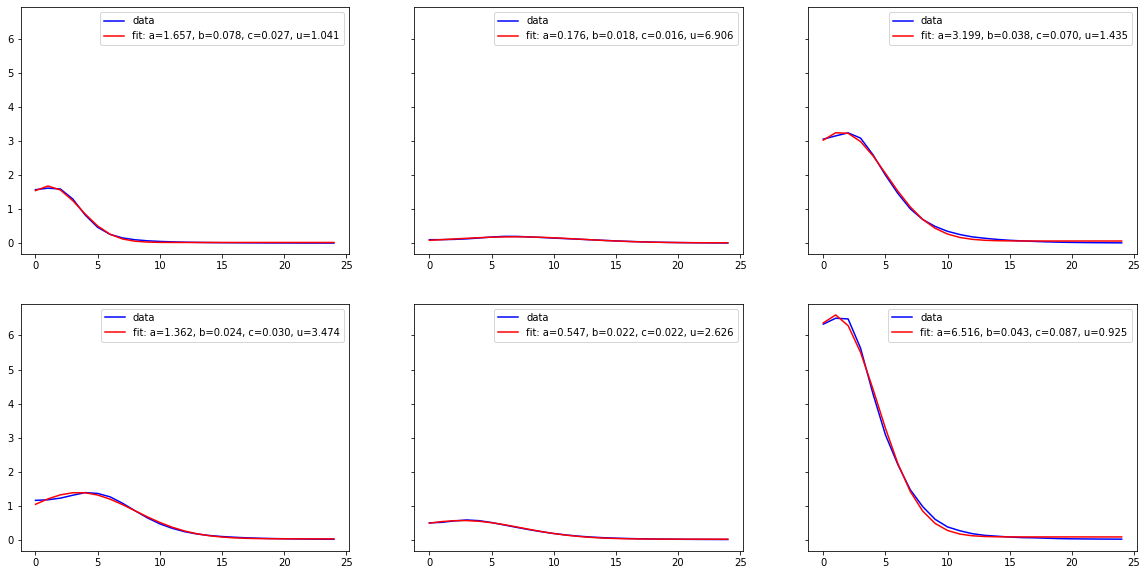

In [16]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c
xdata = np.linspace(0, 24, 25)

fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for i in range(centers.shape[0]):
    ydata = centers[i, :]
    ax[i // 3, i % 3].plot(xdata, ydata, 'b-', label='data')

    popt, pcov = curve_fit(func, xdata, ydata)
    ax[i // 3, i % 3].plot(xdata, func(xdata, *popt), 'r-',
            label='fit: a=%5.3f, b=%5.3f, c=%5.3f, u=%5.3f' % tuple(popt))

    ax[i // 3, i % 3].legend()

Now that we have our distributions and our train-test split, lets train a neural net on 5 depths using our training set.

In [6]:
# gather our specific inputs / outputs
X_train_dtc = train_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test_dtc = test_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# outputs: depth_bin_0 (0-10m), depth_bin_3 (30-40m), depth_bin_6 (70-80m), depth_bin_9(90-100m)
label_bins = [0, 3, 6, 9]
Y_train_dtc = train_dtc[['depth_bin_' + str(i) for i in label_bins]]
Y_test_dtc = test_dtc[['depth_bin_' + str(i) for i in label_bins]]

input_dim = X_train_dtc.shape[1]
output_dim = Y_train_dtc.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train_dtc)
X_train_dtc = scaler.transform(X_train_dtc)
X_test_dtc = scaler.transform(X_test_dtc)

In [7]:
nn_model = Sequential()

nn_model.add(Dense(56, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.4))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.4))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                448       
                                                                 
 dropout (Dropout)           (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 28)                1596      
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 116       
                                                                 
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
_________________________________________________________________


In [8]:
# fit the model
nn_history = nn_model.fit(X_train_dtc, Y_train_dtc, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1188/1188 [==============================] - 6s 4ms/step - loss: 0.2365
Epoch 2/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1872
Epoch 3/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1733
Epoch 4/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1686
Epoch 5/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1627
Epoch 6/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1638
Epoch 7/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1622
Epoch 8/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1570
Epoch 9/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1621
Epoch 10/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1580


**Get predictions out of neural net**

In [9]:
preds = nn_model.predict(X_test_dtc)
actuals = Y_test_dtc.to_numpy()

210/210 [==============================] - 0s 2ms/step


**Interpolate predicted values and fit gaussian parameters**

In [70]:
optimal_params = list()
xdata = np.linspace(0, 9, 4)
xnew = np.linspace(0, 9, 25)
bounds = ([-1.146, -0.997, 0, -1.065], [10, 1.956, 0.5, 4.495])
for p in preds[:30, :]:
    f = interp1d(xdata, p, kind='cubic')
    pinter = f(xnew)
    try:
        popt, pcov = curve_fit(func, xnew, pinter, bounds=bounds)
    except RuntimeError:
        continue
    optimal_params.append(popt)

**Plot full depth values with optimal params and save inter/exterpolated prediction values**

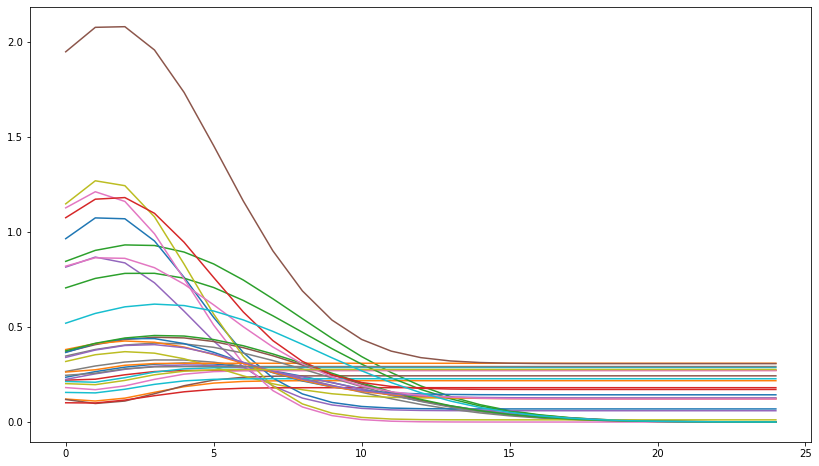

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
xlong = np.linspace(0, 24, 25)
ylong_preds = list()
for opt in optimal_params:
    ylong = func(xlong, *opt)
    ylong_preds.append(ylong)
    ax.plot(xlong, ylong)
plt.show()

ylong_preds = pd.DataFrame(np.array(ylong_preds)).rename({k:v for (k,v) in zip([i for i in range(25)], ['depth_bin_' + str(i) for i in range(25)])}, axis=1)

**Predict clusters using the above data and our kmeans model from earlier**

In [86]:
ylong_preds['cluster'] = kmeans.predict(ylong_preds)

In [129]:
## create a mixing function
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

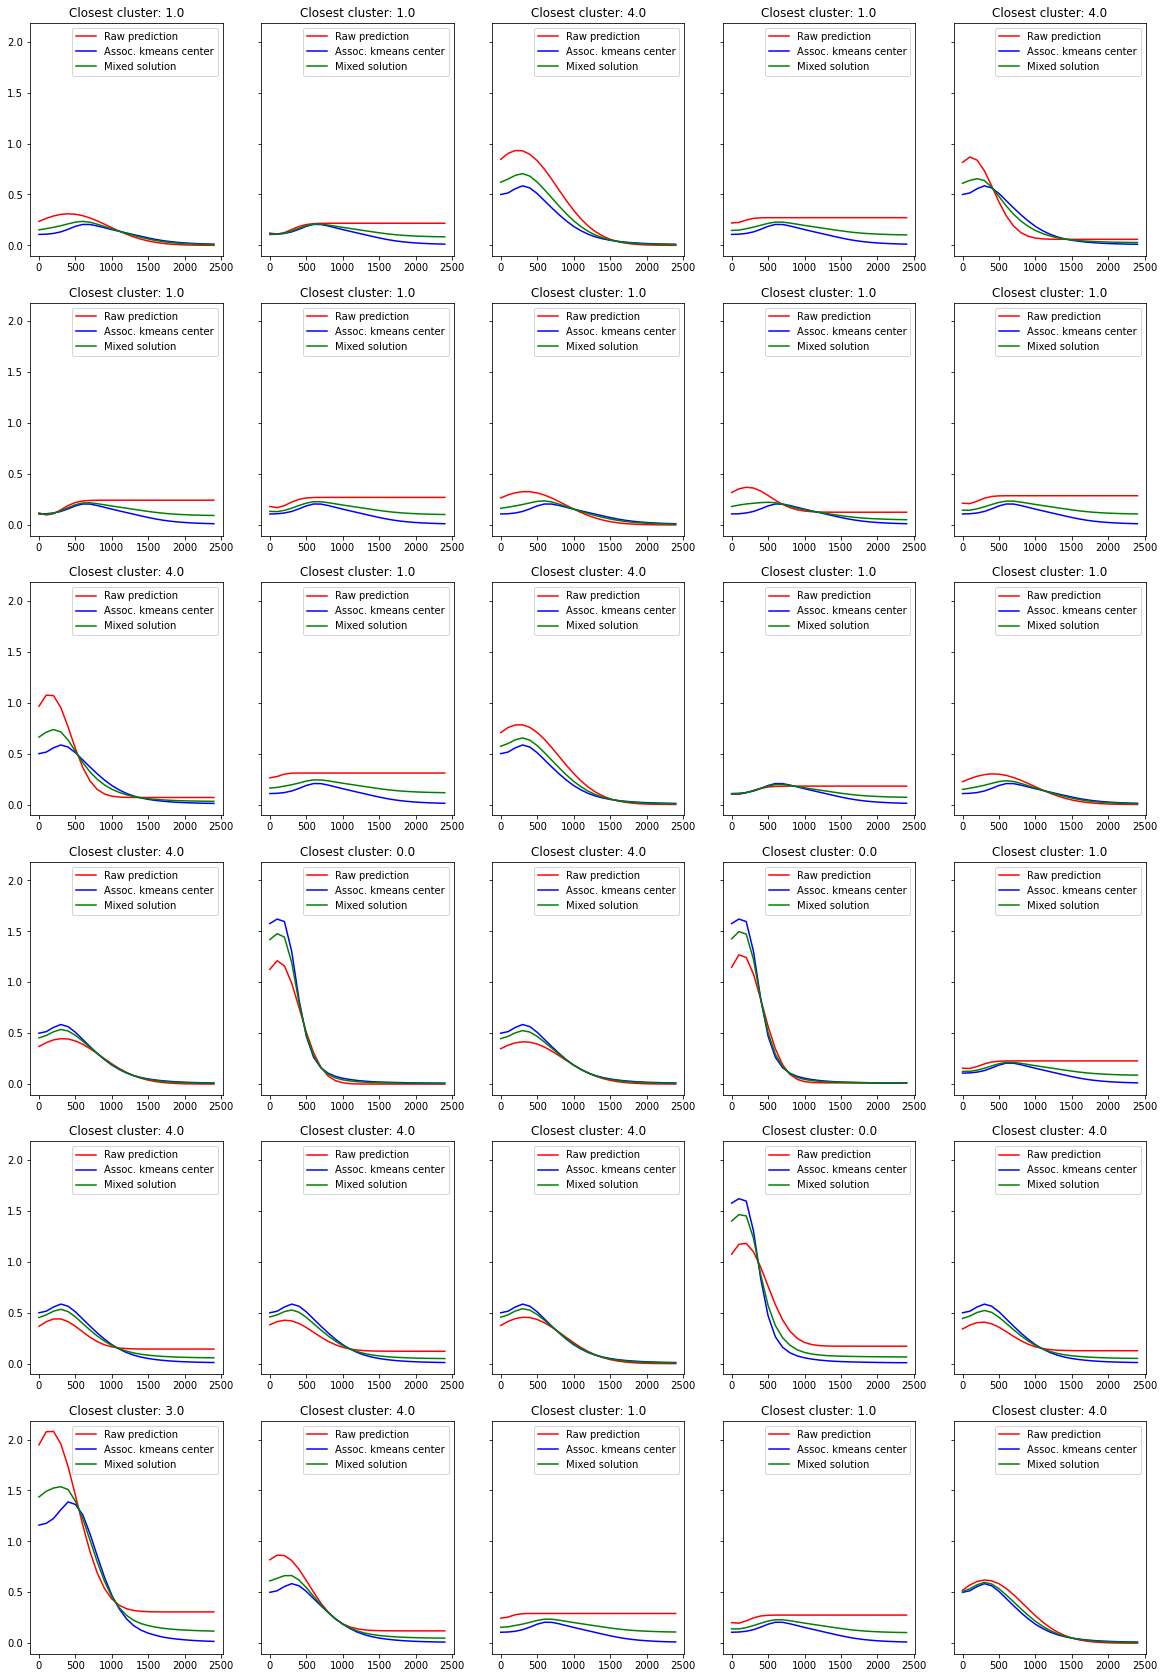

In [130]:
fig, ax = plt.subplots(6, 5, figsize=(20, 30), sharey=True)
for i, r in ylong_preds.iterrows():
    arow = i // 5
    acol = i % 5
    ax[arow, acol].plot(xlong*100, r.iloc[:-1], 'r', label='Raw prediction')
    ax[arow, acol].plot(xlong*100, centers[int(r.cluster), :], 'b', label='Assoc. kmeans center')
    ax[arow, acol].plot(xlong*100, mix_vals(centers[int(r.cluster), :], r.iloc[:-1].to_numpy(), perc_x1=0.65), 'g', label='Mixed solution')
    ax[arow, acol].set_title('Closest cluster: ' + str(r.cluster))
    ax[arow, acol].legend()
plt.show()